In [1]:
from time import perf_counter
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
from collections import defaultdict
from pathlib import Path
from typing import Tuple

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

RS = 47
IMAGE_SIZE = (256, 256)  # (height, width)
CORES = mp.cpu_count()

np.random.seed(RS)

2023-06-09 13:31:48.169327: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-09 13:31:48.220570: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-09 13:31:48.444994: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-09 13:31:48.445911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 13:31:49.653353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [11]:
def get_norm_image_and_face_box(row: pd.Series, root_dir: Path) -> Tuple[np.ndarray, np.ndarray]:    
 
    image = Image.open(root_dir / row['image_name'])
    width, height = image.size
    
    x0 = int((row['x0'] / width) * IMAGE_SIZE[1]) / IMAGE_SIZE[1]
    y0 = int((row['y0'] / height) * IMAGE_SIZE[0]) / IMAGE_SIZE[0]
    x1 = int((row['x1'] / width) * IMAGE_SIZE[1]) / IMAGE_SIZE[1]
    y1 = int((row['y1'] / height) * IMAGE_SIZE[0]) / IMAGE_SIZE[0]
    face_box = np.array([x0, y0, x1, y1])
    
    image = (
        image
        .convert('L')
        .resize(IMAGE_SIZE, Image.LANCZOS)
    )
    image = np.array(image) / 255.

    return image, face_box
    

# 1 face_box per 1 image
def load_dataset(df: pd.DataFrame, mode: str = "default") -> dict:

    assert mode in ["default", "enhanced"]
    
    dataset = defaultdict(dict)
    
    r_d = {"default" : DATA_DIR, "enhanced": ENHANCED_IMAGES_DIR}
    step_printing = df.shape[0] // 10
    get_norm_image_and_face_box_partial = partial(get_norm_image_and_face_box, root_dir=r_d[mode])
    
    with ProcessPoolExecutor(max_workers=CORES) as executor:
        futures = {executor.submit(get_norm_image_and_face_box_partial, row): row['image_name'] for _, row in df.iterrows()}
        for future in as_completed(futures):
            index = futures[future]
            image, face_box = future.result()
            
            dataset[index].update({"image": image, "box": face_box})
            
            if len(dataset) % step_printing == 0:
                print(f"Processed {len(dataset)}/{df.shape[0]} images")
    print(f"Processed {round(len(dataset) / df.shape[0] * 100, 1)}% images")
    
    return dataset


def get_image_and_box_dataset_from_dict(data_dict: dict) -> Tuple[np.ndarray, np.ndarray]:

    arr_img, arr_box = [], []
    
    for d in data_dict.values():
        arr_img.append(d['image'])
        arr_box.append(d['box'])
    assert len(arr_img) == len(arr_box)
    
    arr_box = np.array(arr_box)
    arr_img = np.array(arr_img)
    arr_img = np.expand_dims(arr_img, axis=-1)
    
    return arr_img, arr_box


def get_train_valid_test_by_indexes(data_dict: dict, ids: Tuple[int]) -> Tuple[np.ndarray]:

    X_train_ids, X_valid_ids, X_test_ids, y_train_ids, y_valid_ids, y_test_ids = ids
    images, face_boxes = get_image_and_box_dataset_from_dict(data_dict)

    X_train = images[X_train_ids]
    X_valid = images[X_valid_ids]
    X_test = images[X_test_ids]
    y_train = face_boxes[y_train_ids]
    y_valid = face_boxes[y_valid_ids]
    y_test = face_boxes[y_test_ids]
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


def plot_metric(history: keras.callbacks.History, metric: str, k: int = 5) -> None:

    assert metric in ['accuracy', 'loss'], "Wrong type of metric. Just use 'accuracy' or 'loss'"
    
    train_metrics = history.history[metric]
    val_metrics = history.history[f'val_{metric}']
    epochs = range(1, len(train_metrics) + 1)
    
    plt.plot(epochs, train_metrics, '-o', markersize=3, label=f"Training {metric}")
    plt.plot(epochs, val_metrics, label=f"Validation {metric}")
    
    plt.xticks([1] + [i for i in epochs if i % k == 0])
    
    plt.title(f'Training and validation {metric}')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()


def plot_image_with_predicted_box(model, image: np.ndarray) -> None:

    box = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    print(box)
    
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image).convert('RGB')
    draw = ImageDraw.Draw(image)
    
    x0 = int(box[0] * IMAGE_SIZE[1])
    y0 = int(box[1] * IMAGE_SIZE[0])
    x1 = int(box[2] * IMAGE_SIZE[1])
    y1 = int(box[3] * IMAGE_SIZE[0])

    draw.rectangle(((x0, y0), (x1, y1)), outline='red')

    #image.show()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [12]:
ENHANCED_IMAGES_DIR = Path.cwd().parent / "data" / "lab2" / "images_enhanced"
DATA_DIR = Path.cwd().parent / "data" / "lab2" / "images"
FACES_FILE = Path.cwd().parent / "data" / "lab2" / "faces.csv"
CHECKPOINTS_DIR = Path('checkpoints')
CHECKPOINTS_DIR.mkdir(exist_ok=True)

In [13]:
metadata_full = pd.read_csv(FACES_FILE).drop_duplicates(subset=['image_name']).reset_index(drop=True)
metadata_full

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166
...,...,...,...,...,...,...,...
2199,00003138.jpg,508,339,207,72,444,260
2200,00001049.jpg,1024,683,345,83,736,387
2201,00002540.jpg,276,340,71,62,172,206
2202,00002554.jpg,1200,900,451,107,707,330


In [14]:
ids_imgs = list(i.name for i in ENHANCED_IMAGES_DIR.glob('*'))
metadata_selected = metadata_full[metadata_full['image_name'].isin(ids_imgs)].reset_index(drop=True)
metadata_selected

,image_name,width,height,x0,y0,x1,y1
0,00001736.jpg,626,417,147,14,519,303
1,00003121.jpg,626,418,462,60,599,166
2,00002571.jpg,960,720,117,159,317,334
3,00000366.jpg,900,601,170,88,506,350
4,00001087.jpg,1024,683,405,27,614,189
...,...,...,...,...,...,...,...
693,00001707.jpg,800,534,381,13,575,160
694,00003138.jpg,508,339,207,72,444,260
695,00001049.jpg,1024,683,345,83,736,387
696,00002540.jpg,276,340,71,62,172,206


In [15]:
# dataset = load_dataset(metadata_selected, mode="enhanced")
dataset = load_dataset(metadata_full, mode="default")

Processed 220/2204 images
Processed 440/2204 images
Processed 660/2204 images
Processed 880/2204 images
Processed 1100/2204 images
Processed 1320/2204 images
Processed 1540/2204 images
Processed 1760/2204 images
Processed 1980/2204 images
Processed 2200/2204 images
Processed 100.0% images


In [16]:
indexes = list(range(len(dataset)))

X_train_ids, X_test_ids, y_train_ids, y_test_ids = train_test_split(indexes, indexes, test_size=0.2, random_state=RS)
X_train_ids, X_valid_ids, y_train_ids, y_valid_ids = train_test_split(X_train_ids, y_train_ids, test_size=0.2, random_state=RS)

tuple_of_indexes = (X_train_ids, X_valid_ids, X_test_ids, y_train_ids, y_valid_ids, y_test_ids)
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test_by_indexes(dataset, tuple_of_indexes)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((1410, 256, 256, 1),
 (353, 256, 256, 1),
 (441, 256, 256, 1),
 (1410, 4),
 (353, 4),
 (441, 4))

In [17]:
def model_CNN(height: int, width: int):
    model = Sequential()
    model.add(Conv2D(32, 3, input_shape=(height, width, 1), activation='relu'))
    model.add(Dropout(0.1))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(256, 3, activation='relu'))
    model.add(Dropout(0.4))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(4, activation = 'sigmoid'))
    return model

In [18]:
def build_train_eval_plot(
    X_train, y_train, X_valid, y_valid, X_test, y_test, custom_text: str,
    batch_size: int, epochs: int, optimizer: str, lr: float = 0.001
) -> None:

    assert optimizer in ("Adam", "SGD", "RMSprop")
    
    opt = {
        "Adam": keras.optimizers.Adam(learning_rate=lr),
        "SGD": keras.optimizers.SGD(learning_rate=lr),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=lr),
    }
    
    cnn = model_CNN(*IMAGE_SIZE)
    cnn.compile(optimizer=opt[optimizer], loss='mse', metrics=['accuracy'])
    cnn.summary()
    
    suffix_name = f"layers-{len(cnn.layers)}_opt-{optimizer}_lr-{lr}_{custom_text}"
    checkpoint_name = f"best-CNN_{suffix_name}.hdf5"
    
    checkpoint = ModelCheckpoint(CHECKPOINTS_DIR / checkpoint_name, monitor='val_loss', 
                                 verbose=1, save_best_only=True, save_freq='epoch')
    
    time1 = perf_counter()
    history = cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                      batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], 
                      use_multiprocessing=True, workers=CORES, verbose=1)
    time_to_train = perf_counter() - time1
    
    plot_metric(history, 'loss', k=1)
    plot_metric(history, 'accuracy', k=1)
    
    cnn = load_model(CHECKPOINTS_DIR / checkpoint_name)
    
    time1 = perf_counter()
    print("\nEval scores:")
    cnn.evaluate(X_test, y_test, batch_size=batch_size)
    time_to_eval = perf_counter() - time1
    
    plot_image_with_predicted_box(cnn, dataset['00001033.jpg']['image'])
    
    print(f"================ {Path(checkpoint_name).stem} ================")
    print(f"batch_size: {batch_size} | epoch: {epochs}")
    print(f"Time to train model: {time_to_train:.2f} sec")
    print(f"Time to eval model: {time_to_eval:.2f} sec")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 dropout_4 (Dropout)         (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 127, 127, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 dropout_5 (Dropout)         (None, 125, 125, 64)     

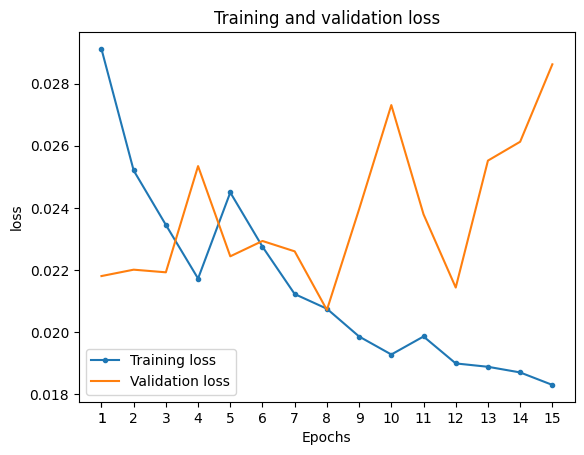

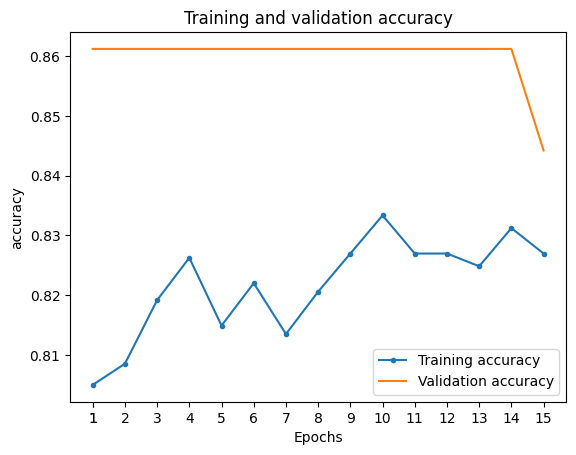


Eval scores:
14/14 [==============================] - 6s 424ms/step - loss: 0.0243 - accuracy: 0.8141
[0.39198118 0.15002091 0.6416931  0.4339665 ]


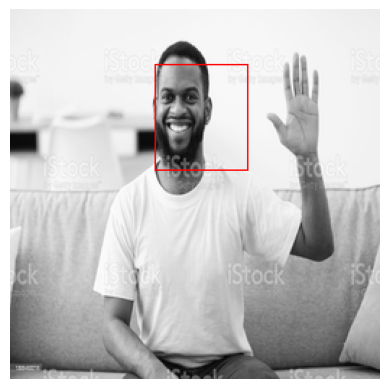

================ best-CNN_layers-19_opt-Adam_lr-0.001_default ================
batch_size: 32 | epoch: 15
Time to train model: 1227.92 sec
Time to eval model: 6.13 sec


In [19]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'Adam', 0.001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 dropout_8 (Dropout)         (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 127, 127, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 dropout_9 (Dropout)         (None, 125, 125, 64)     

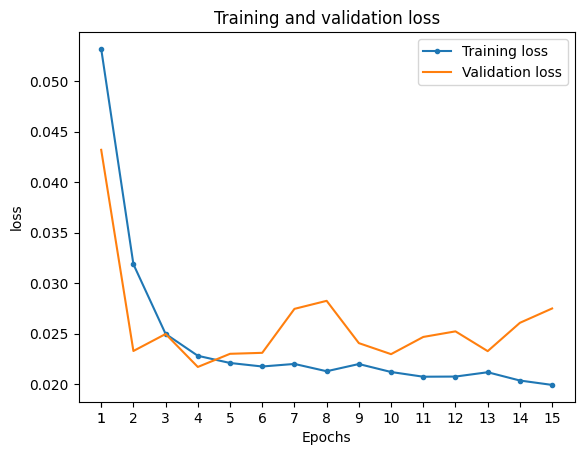

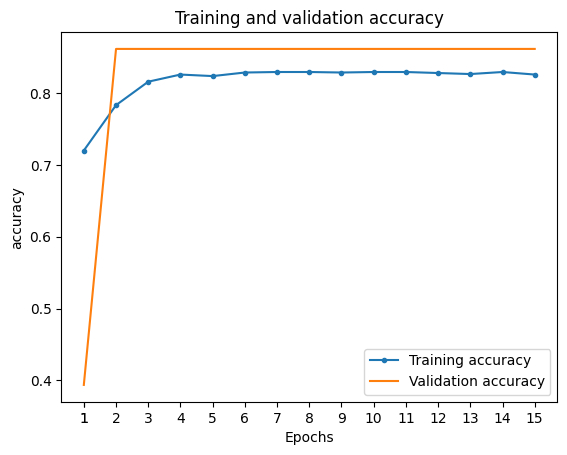


Eval scores:
14/14 [==============================] - 5s 374ms/step - loss: 0.0256 - accuracy: 0.8141
[0.37319738 0.12570529 0.6418322  0.38694948]


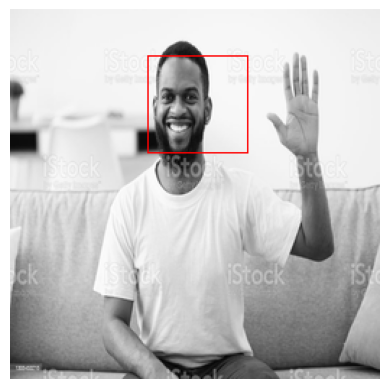

================ best-CNN_layers-19_opt-Adam_lr-0.01_default ================
batch_size: 32 | epoch: 15
Time to train model: 1160.60 sec
Time to eval model: 5.40 sec


In [20]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'Adam', 0.01)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 dropout_12 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 dropout_13 (Dropout)        (None, 125, 125, 64)     

45/45 [==============================] - 75s 2s/step - loss: 0.0338 - accuracy: 0.8071 - val_loss: 0.0532 - val_accuracy: 0.8414
Epoch 15/15
45/45 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.8078
Epoch 15: val_loss improved from 0.05320 to 0.05253, saving model to checkpoints/best-CNN_layers-19_opt-SGD_lr-0.001_default.hdf5
45/45 [==============================] - 76s 2s/step - loss: 0.0334 - accuracy: 0.8078 - val_loss: 0.0525 - val_accuracy: 0.8272


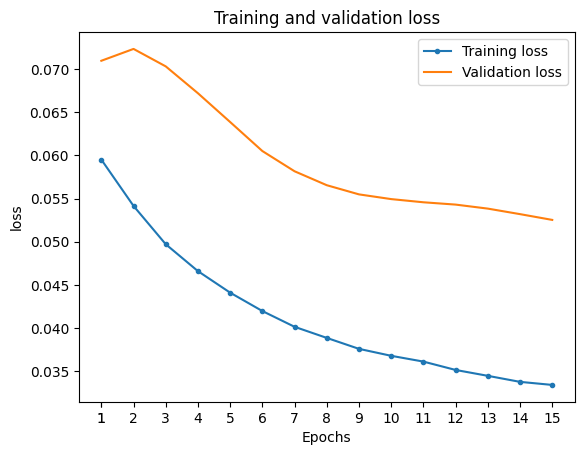

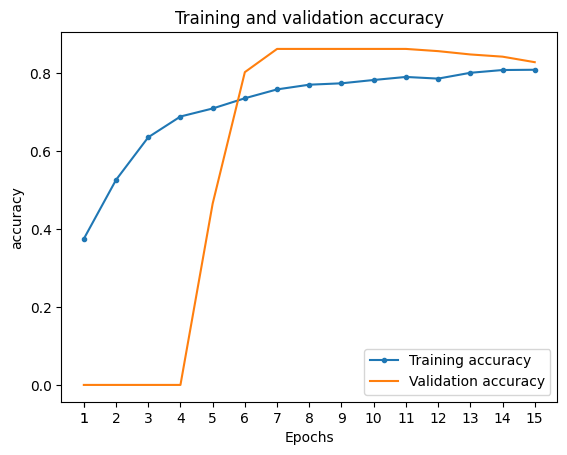


Eval scores:
14/14 [==============================] - 5s 361ms/step - loss: 0.0530 - accuracy: 0.7664
[0.3335789  0.48655576 0.591455   0.5127909 ]


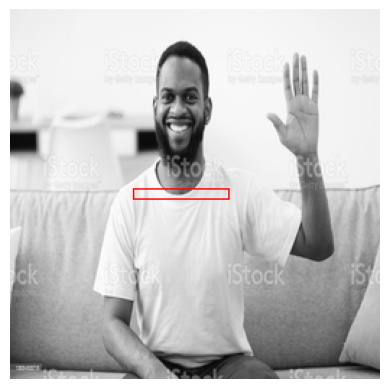

================ best-CNN_layers-19_opt-SGD_lr-0.001_default ================
batch_size: 32 | epoch: 15
Time to train model: 1111.72 sec
Time to eval model: 5.25 sec


In [21]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'SGD', 0.001)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 dropout_16 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 dropout_17 (Dropout)        (None, 125, 125, 64)     

45/45 [==============================] - 72s 2s/step - loss: 0.0240 - accuracy: 0.8262 - val_loss: 0.0304 - val_accuracy: 0.8612
Epoch 15/15
45/45 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.8248
Epoch 15: val_loss improved from 0.03037 to 0.03030, saving model to checkpoints/best-CNN_layers-19_opt-SGD_lr-0.01_default.hdf5
45/45 [==============================] - 72s 2s/step - loss: 0.0239 - accuracy: 0.8248 - val_loss: 0.0303 - val_accuracy: 0.8640


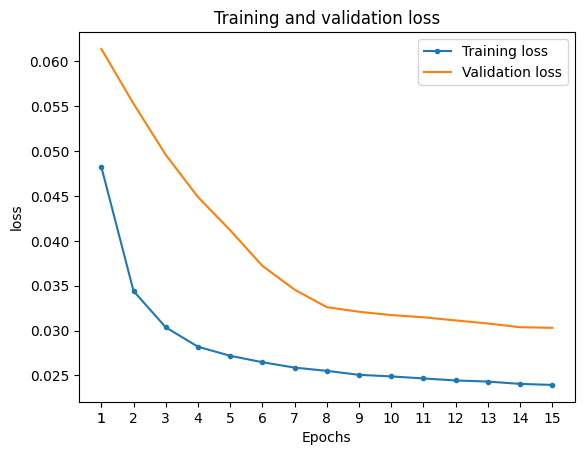

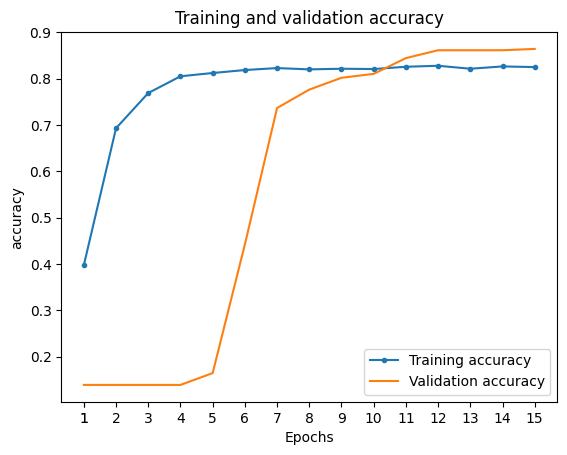


Eval scores:
14/14 [==============================] - 5s 368ms/step - loss: 0.0327 - accuracy: 0.8073
[0.4502918  0.1913336  0.658658   0.58678496]


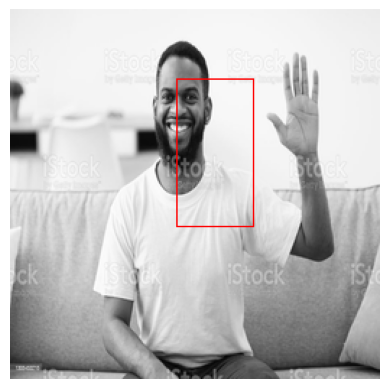

================ best-CNN_layers-19_opt-SGD_lr-0.01_default ================
batch_size: 32 | epoch: 15
Time to train model: 1100.27 sec
Time to eval model: 5.29 sec


In [22]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'SGD', 0.01)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 dropout_20 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 dropout_21 (Dropout)        (None, 125, 125, 64)     

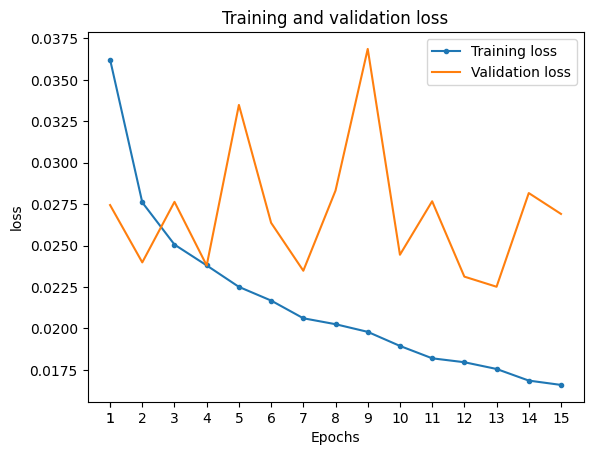

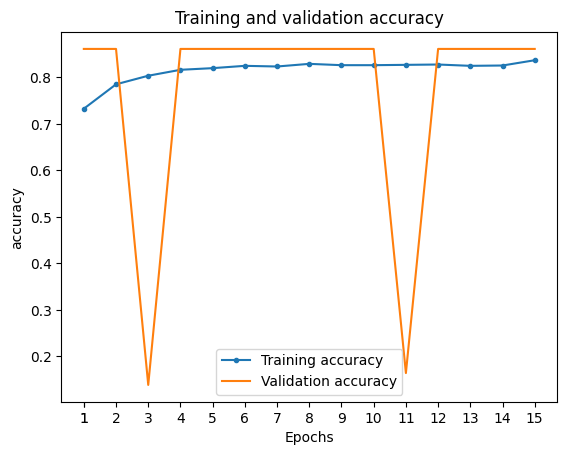


Eval scores:
14/14 [==============================] - 5s 361ms/step - loss: 0.0265 - accuracy: 0.8141
[0.34008375 0.09976681 0.5799712  0.40798986]


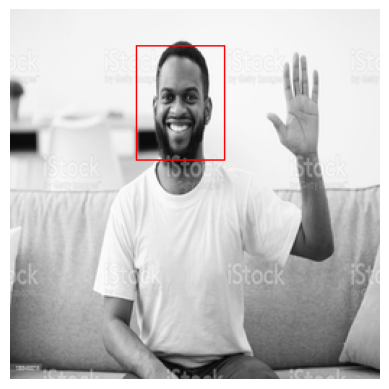

================ best-CNN_layers-19_opt-RMSprop_lr-0.001_default ================
batch_size: 32 | epoch: 15
Time to train model: 1080.45 sec
Time to eval model: 5.23 sec


In [23]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'RMSprop', 0.001)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 dropout_24 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 dropout_25 (Dropout)        (None, 125, 125, 64)     

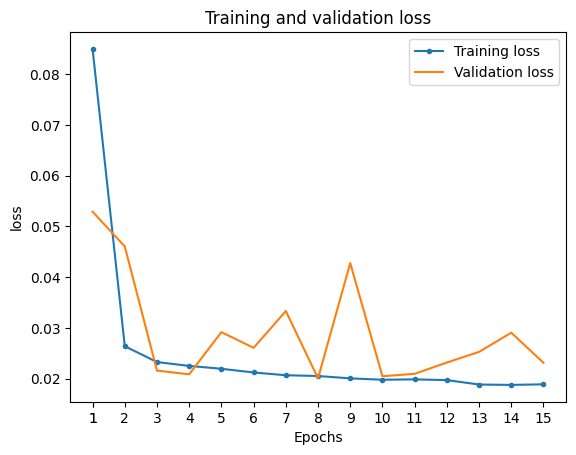

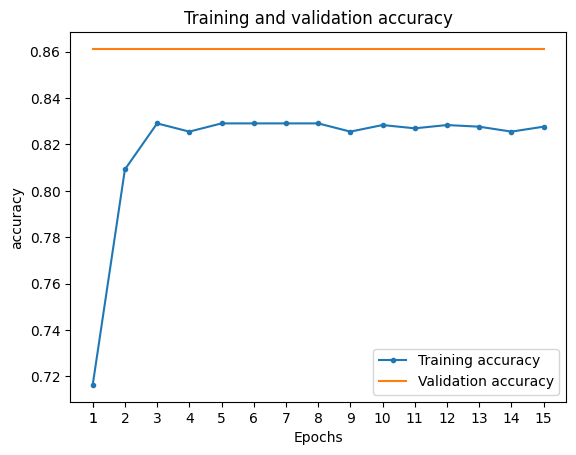


Eval scores:
14/14 [==============================] - 5s 348ms/step - loss: 0.0233 - accuracy: 0.8141
[0.3769137  0.18303116 0.6283787  0.4680116 ]


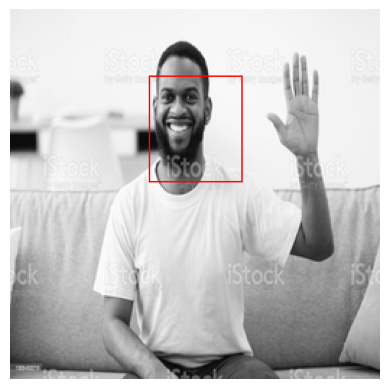

================ best-CNN_layers-19_opt-RMSprop_lr-0.01_default ================
batch_size: 32 | epoch: 15
Time to train model: 1105.93 sec
Time to eval model: 5.04 sec


In [24]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'default', 32, 15, 'RMSprop', 0.01)

In [25]:
def model_CNN(height: int, width: int):
    model = Sequential()
    model.add(Conv2D(64, 3, input_shape=(height, width, 1), activation='relu'))
    model.add(Dropout(0.1))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(256, 3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(512, 3, activation='relu'))
    model.add(Dropout(0.4))
    model.add(MaxPool2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(4, activation = 'sigmoid'))
    return model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 254, 254, 64)      640       
                                                                 
 dropout_28 (Dropout)        (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_28 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 dropout_29 (Dropout)        (None, 125, 125, 128)    

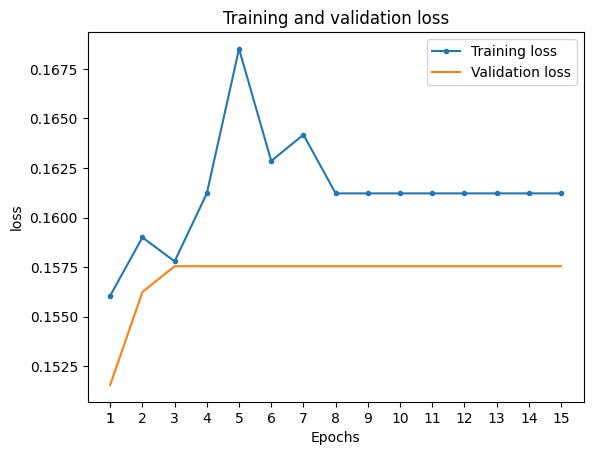

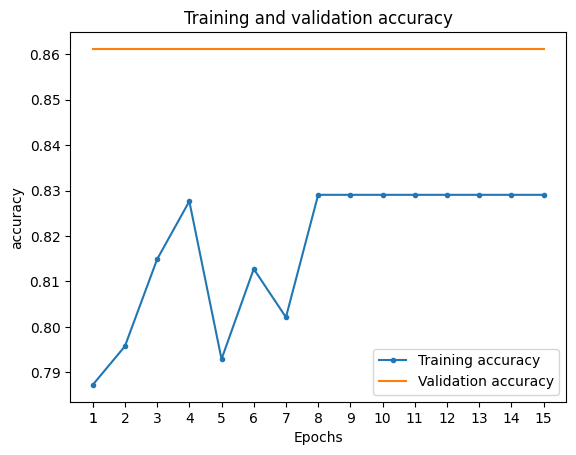


Eval scores:
14/14 [==============================] - 16s 1s/step - loss: 0.1612 - accuracy: 0.8141
[0. 0. 1. 1.]


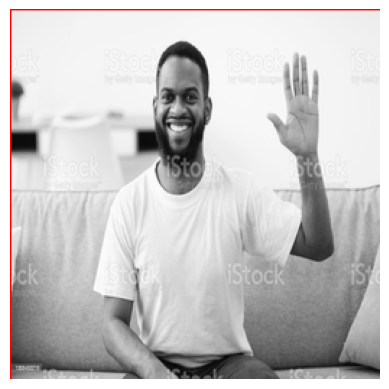

================ best-CNN_layers-19_opt-RMSprop_lr-0.01_more_complex ================
batch_size: 32 | epoch: 15
Time to train model: 3300.70 sec
Time to eval model: 16.56 sec


In [26]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'more_complex', 32, 15, 'RMSprop', 0.01)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 254, 254, 64)      640       
                                                                 
 dropout_32 (Dropout)        (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_32 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 128)     73856     
                                                                 
 dropout_33 (Dropout)        (None, 125, 125, 128)    

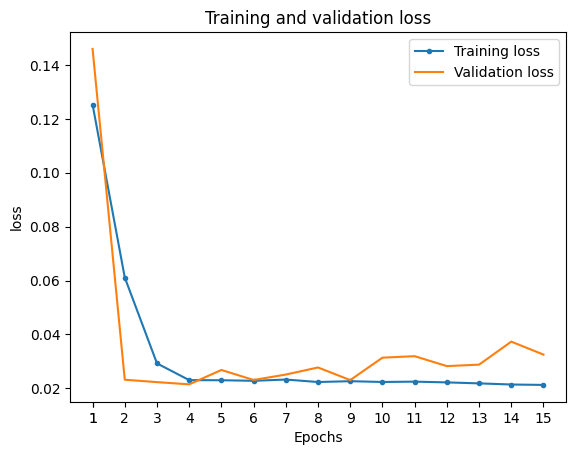

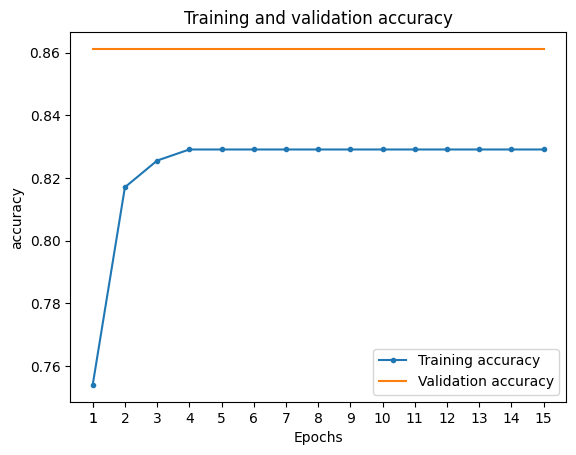


Eval scores:
14/14 [==============================] - 17s 1s/step - loss: 0.0246 - accuracy: 0.8141
[0.3832952  0.16381142 0.6583952  0.49726388]


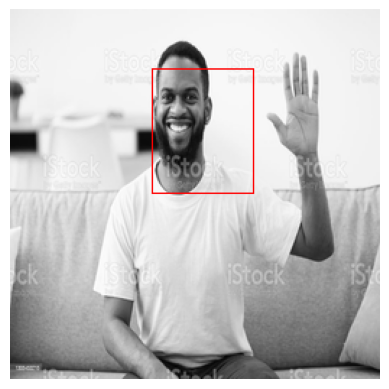

================ best-CNN_layers-19_opt-Adam_lr-0.01_more_complex ================
batch_size: 32 | epoch: 15
Time to train model: 3301.11 sec
Time to eval model: 16.64 sec


In [27]:
build_train_eval_plot(X_train, y_train, X_valid, y_valid, X_test, y_test, 'more_complex', 32, 15, 'Adam', 0.01)

In [30]:
stats = pd.DataFrame({
    'optimizer': ['Adam', 'Adam', 'SGD', 'SGD', 'RMSprop', 'RMSprop', 'RMSprop', 'Adam'],
    'lr': [0.001, 0.01, 0.001, 0.01, 0.001, 0.01, 0.01, 0.01],
    'loss': [0.0243, 0.0256, 0.0530, 0.0327, 0.0265, 0.0233, 0.1612, 0.0246],
    'accuracy': [0.8141, 0.8141, 0.7664, 0.8073, 0.8141, 0.8141, 0.8141, 0.8141],
    'batch_size': [32] * 8,
    'epochs': [15] * 8,
    'nn_architecture': ['default'] * 6 + ['more_complex'] * 2,
    'time_eval': [6.13, 5.40, 5.25, 5.29, 5.23, 5.04, 16.56, 16.64],
    'time_train': [1227.92, 1160.60, 1111.72, 1100.27, 1080.45, 1105.93, 3300.70, 3301.11]
})

In [31]:
stats.sort_values(by=['accuracy', 'loss', 'time_train', 'time_eval'], ascending=[False, True, True, True])

,optimizer,lr,loss,accuracy,batch_size,epochs,nn_architecture,time_eval,time_train
5,RMSprop,0.010,0.0233,0.8141,32,15,default,5.04,1105.93
0,Adam,0.001,0.0243,0.8141,32,15,default,6.13,1227.92
7,Adam,0.010,0.0246,0.8141,32,15,more_complex,16.64,3301.11
1,Adam,0.010,0.0256,0.8141,32,15,default,5.40,1160.60
4,RMSprop,0.001,0.0265,0.8141,32,15,default,5.23,1080.45
6,RMSprop,0.010,0.1612,0.8141,32,15,more_complex,16.56,3300.70
3,SGD,0.010,0.0327,0.8073,32,15,default,5.29,1100.27
2,SGD,0.001,0.0530,0.7664,32,15,default,5.25,1111.72
